<a href="https://colab.research.google.com/github/ulises1229/IA-BLOQUE/blob/main/Tiny_NeRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

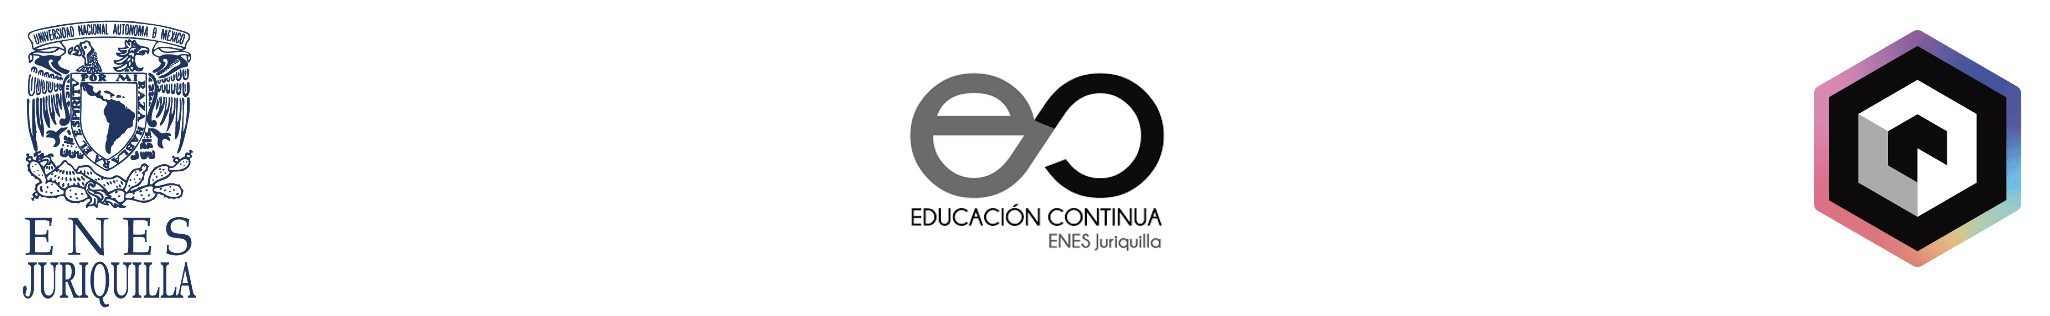

##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*



In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-02-27 04:35:01--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-02-27 04:35:02--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  22.6MB/s    in 0.5s    

2024-02-27 04:35:02 (22.6 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


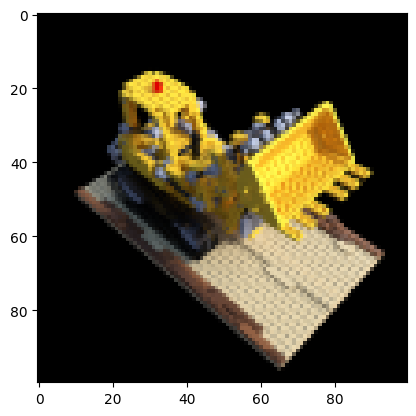

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [ ]:


def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.22978950500488282 secs per iter


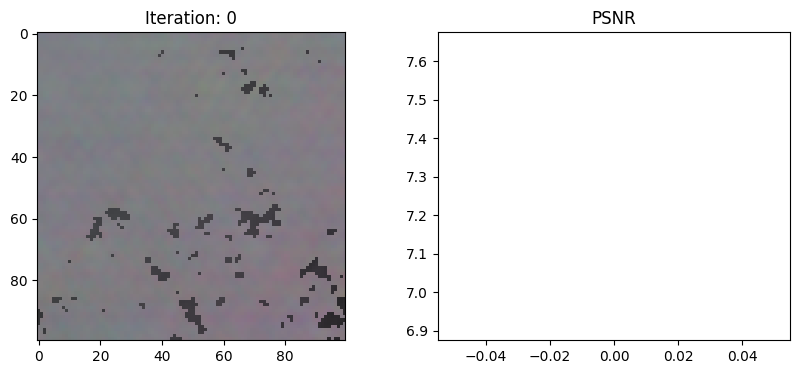

25 0.7504284954071045 secs per iter


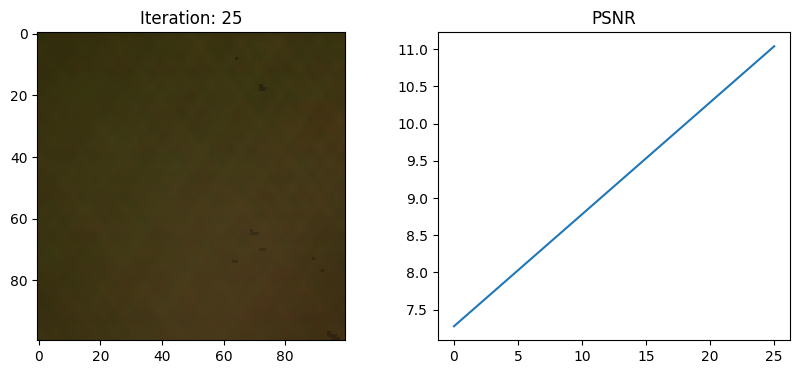

50 0.7628779315948486 secs per iter


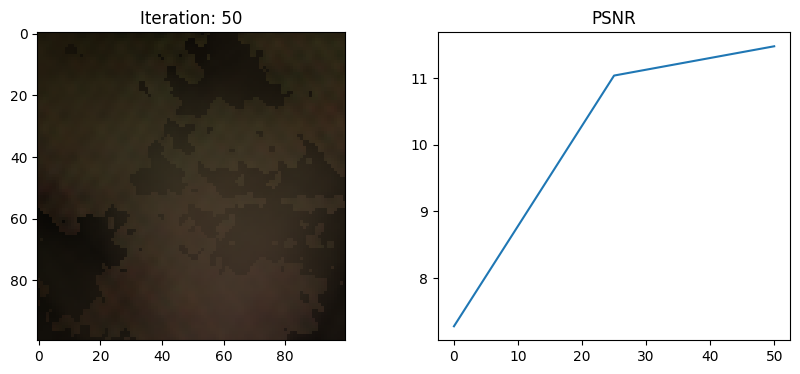

75 0.7496236038208007 secs per iter


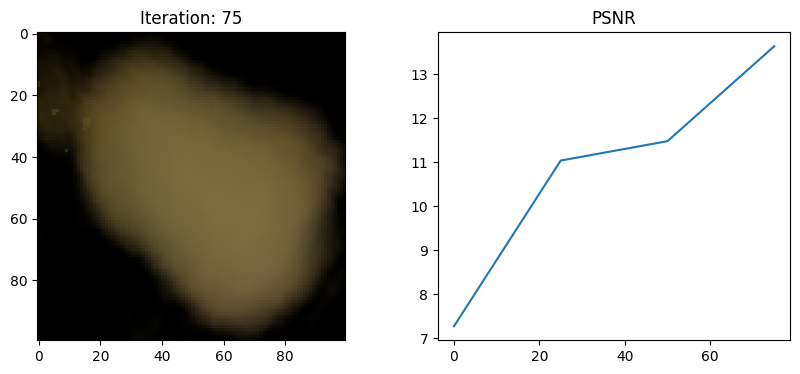

100 0.7387819004058838 secs per iter


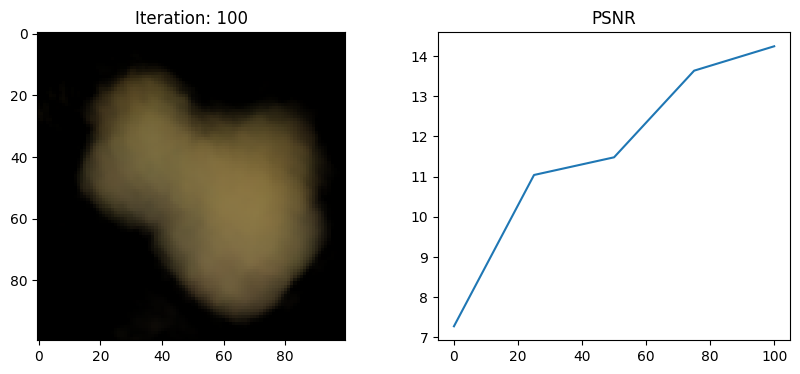

125 0.7791567611694336 secs per iter


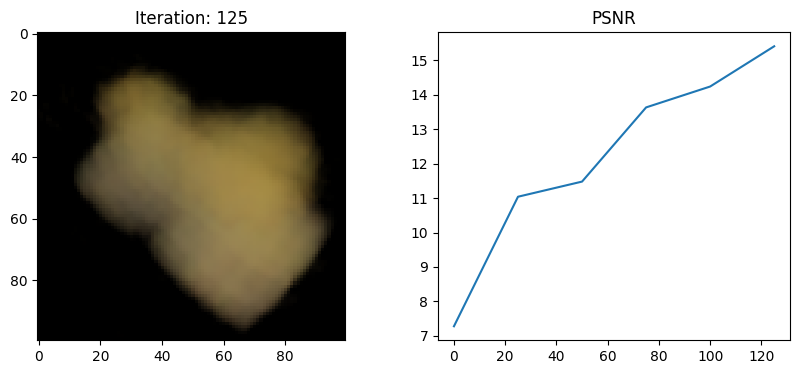

150 0.7709800529479981 secs per iter


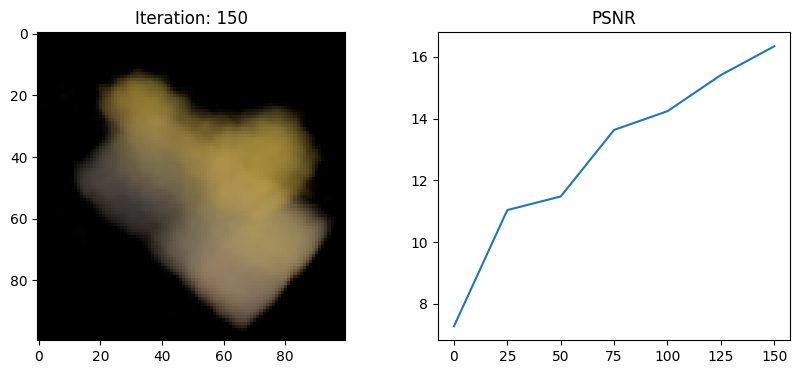

175 0.7895623397827148 secs per iter


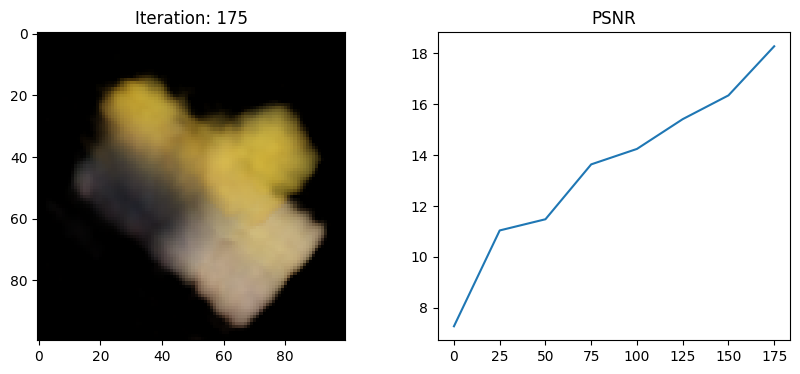

200 0.7947130966186523 secs per iter


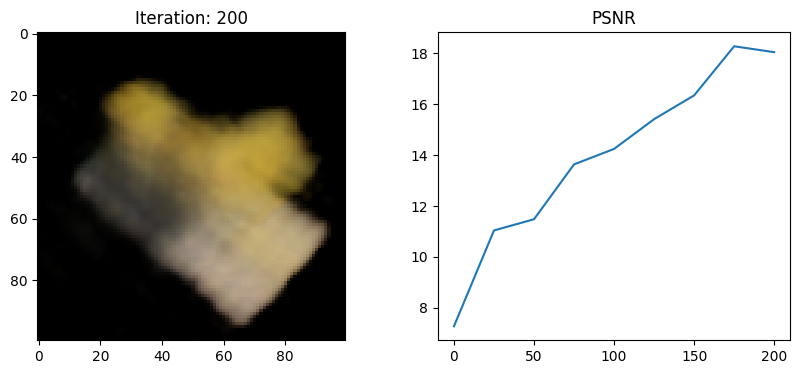

225 0.7917374897003174 secs per iter


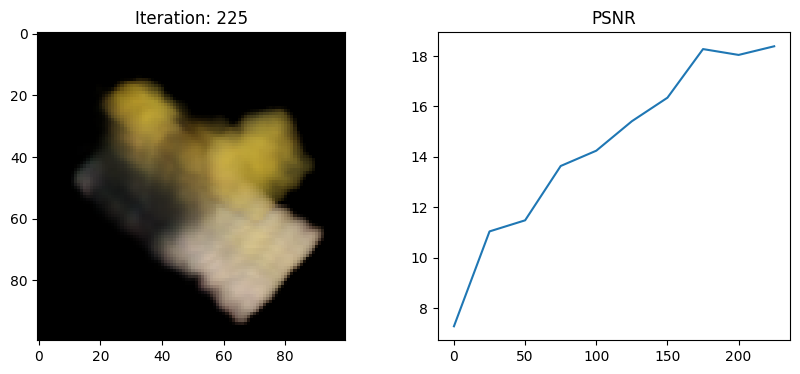

250 0.7833261108398437 secs per iter


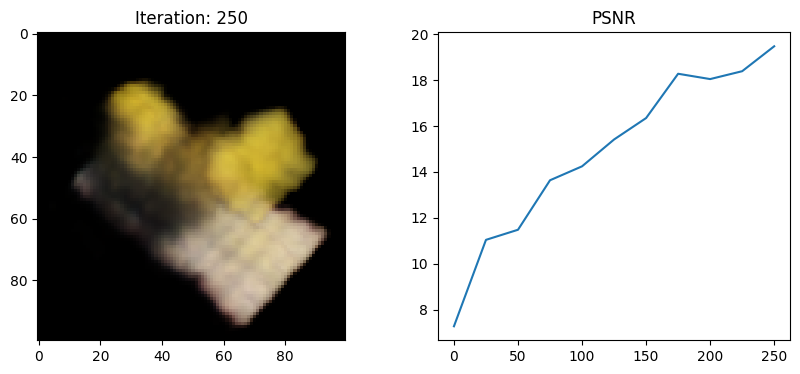

275 0.785153579711914 secs per iter


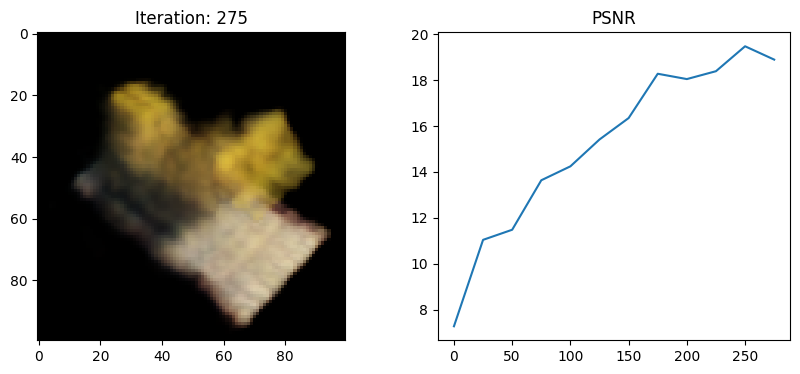

300 0.7941373634338379 secs per iter


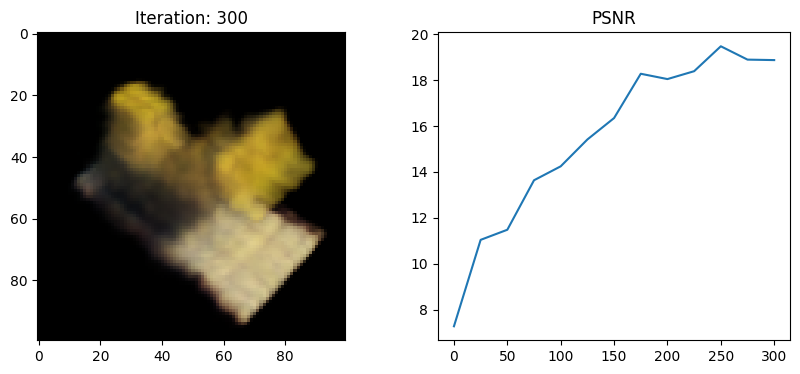

325 0.787841510772705 secs per iter


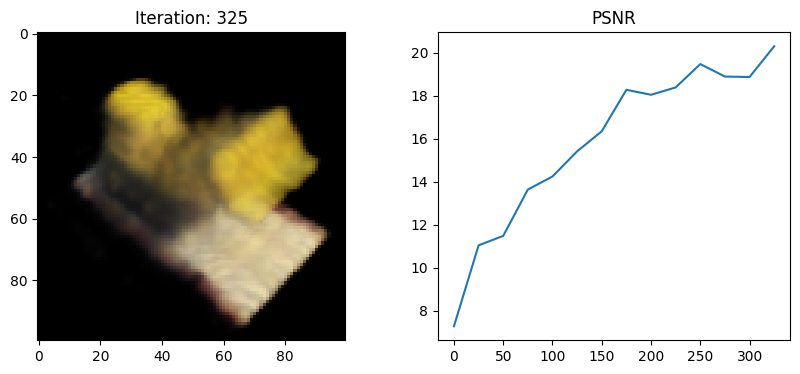

350 0.7877489948272705 secs per iter


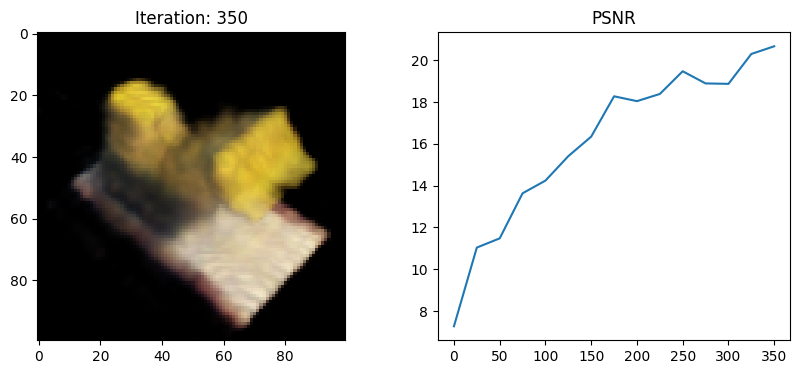

375 0.789078664779663 secs per iter


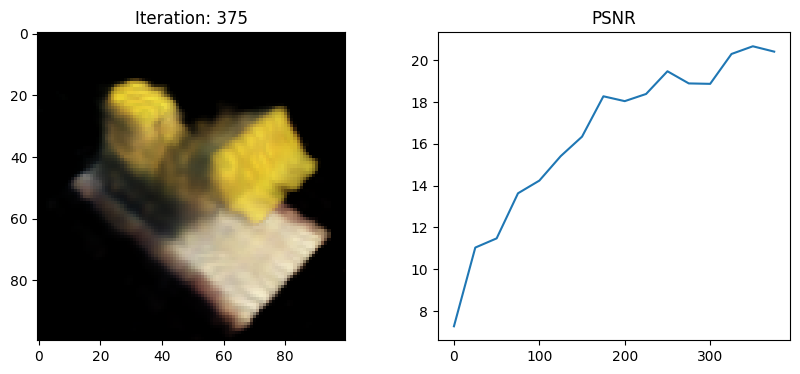

400 0.790611457824707 secs per iter


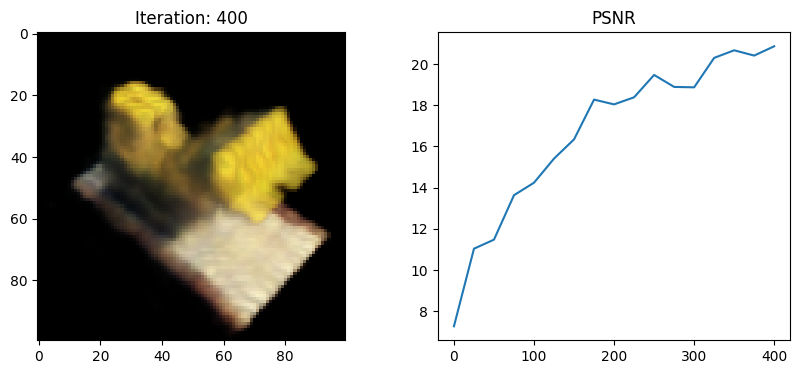

425 0.7876925563812256 secs per iter


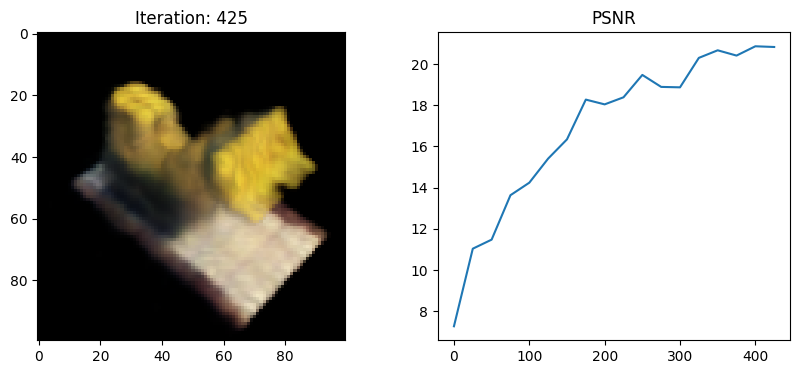

450 0.7878549480438233 secs per iter


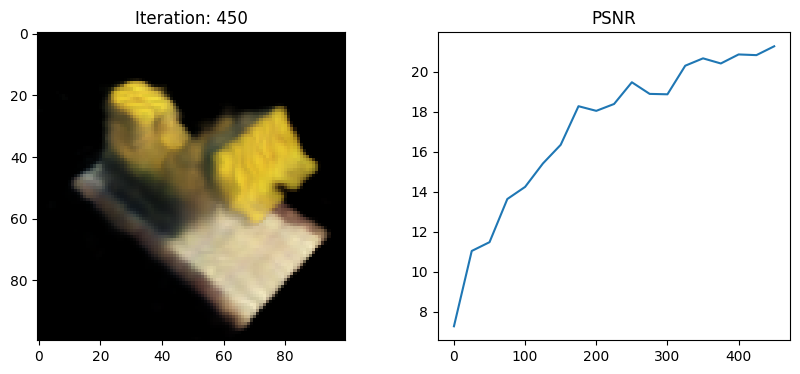

475 0.7886120128631592 secs per iter


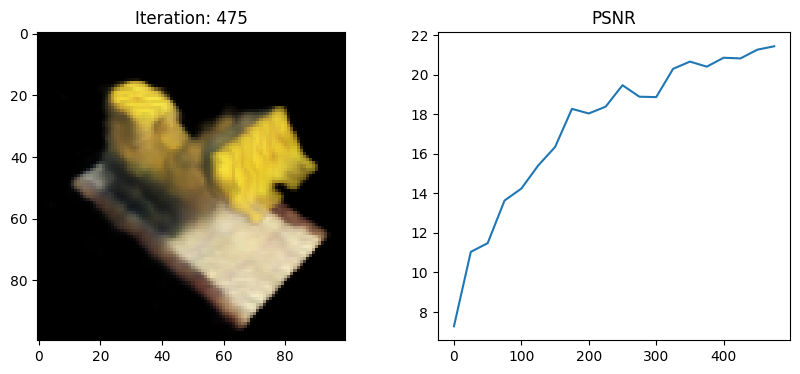

500 0.7915219688415527 secs per iter


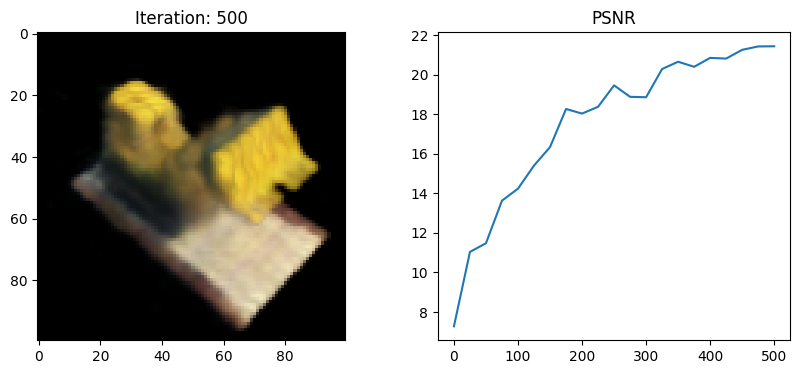

525 0.7879295635223389 secs per iter


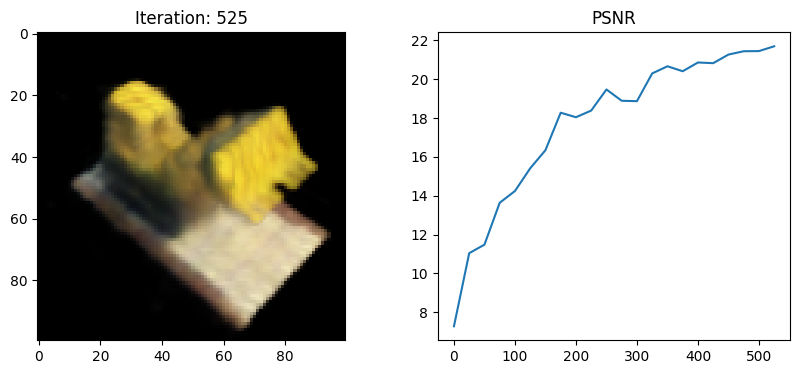

550 0.7897017288208008 secs per iter


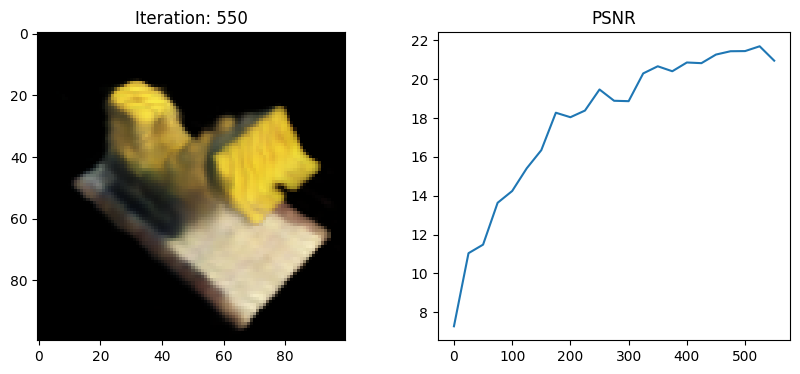

575 0.7840282249450684 secs per iter


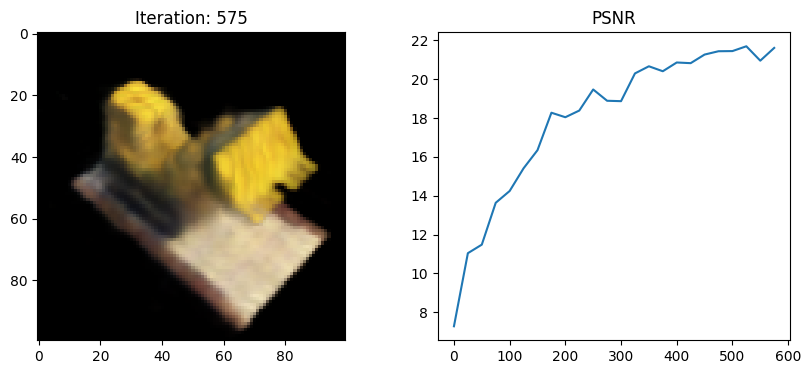

600 0.7876827335357666 secs per iter


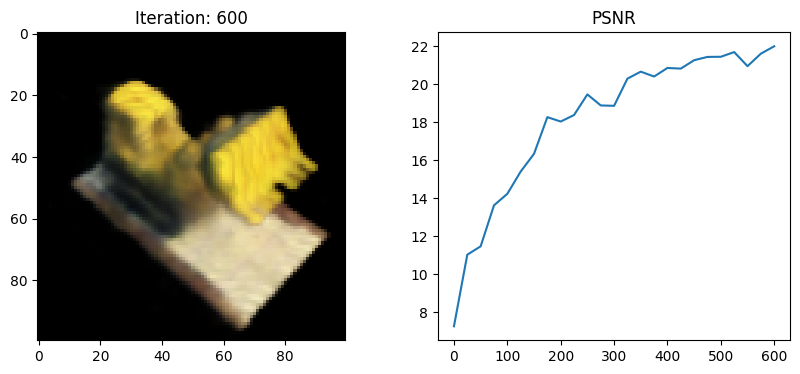

625 0.7866563606262207 secs per iter


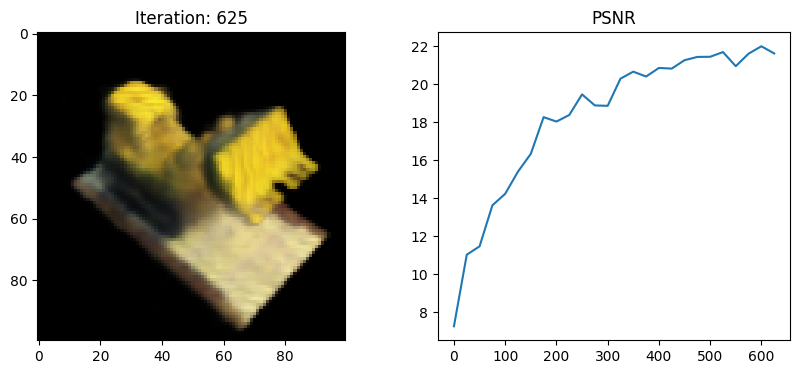

650 0.7877965927124023 secs per iter


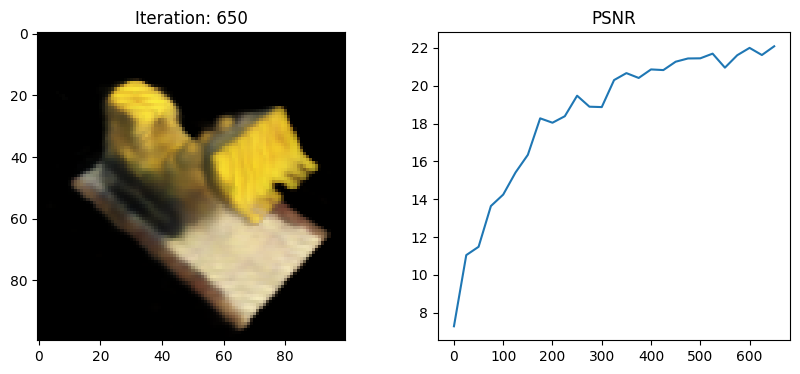

675 0.786394681930542 secs per iter


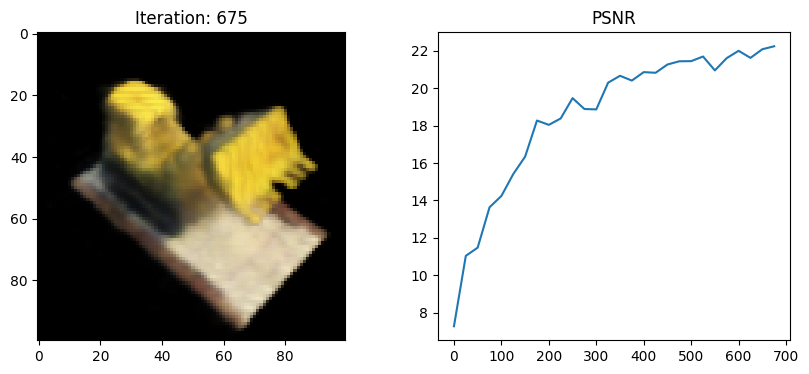

700 0.7884792804718017 secs per iter


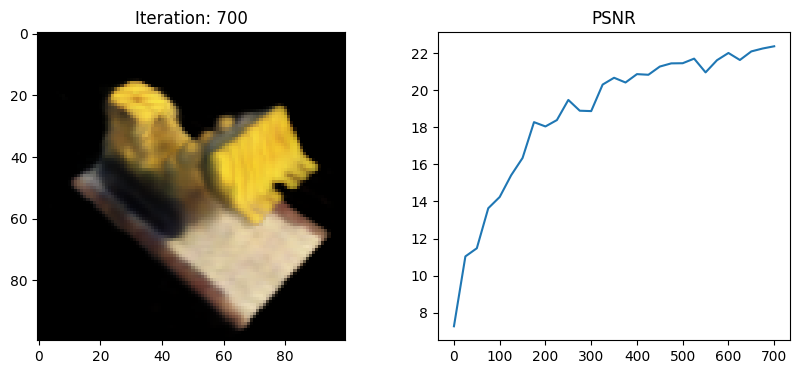

725 0.7924310970306396 secs per iter


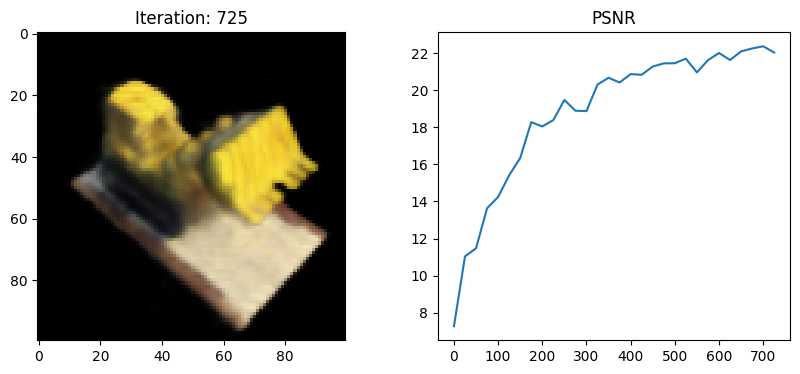

750 0.7872021675109864 secs per iter


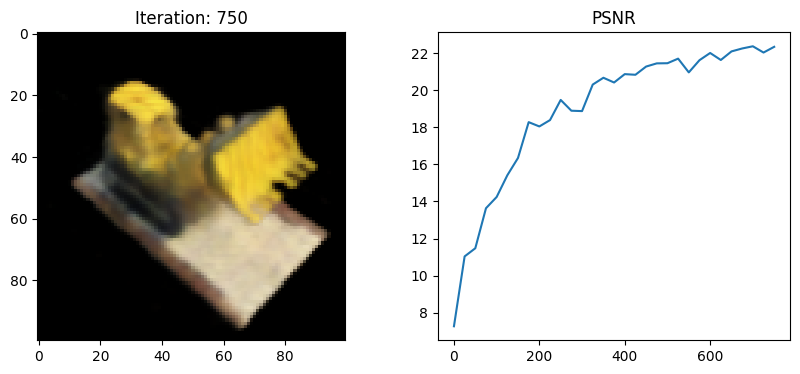

775 0.786979169845581 secs per iter


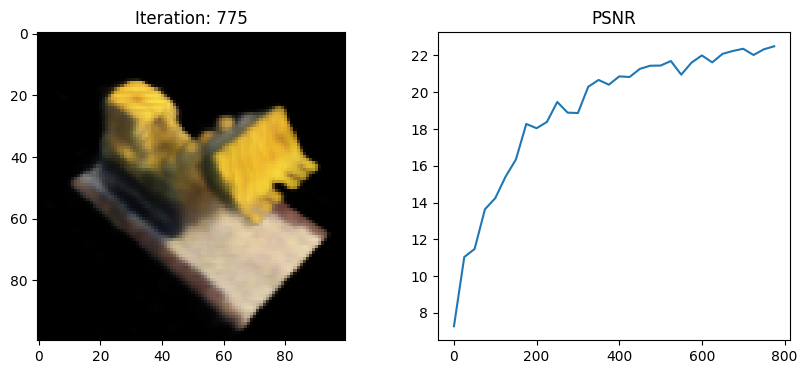

800 0.7909781551361084 secs per iter


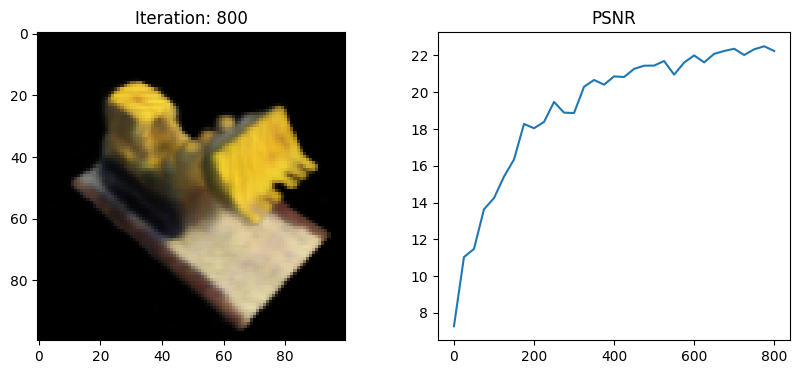

825 0.7848440265655517 secs per iter


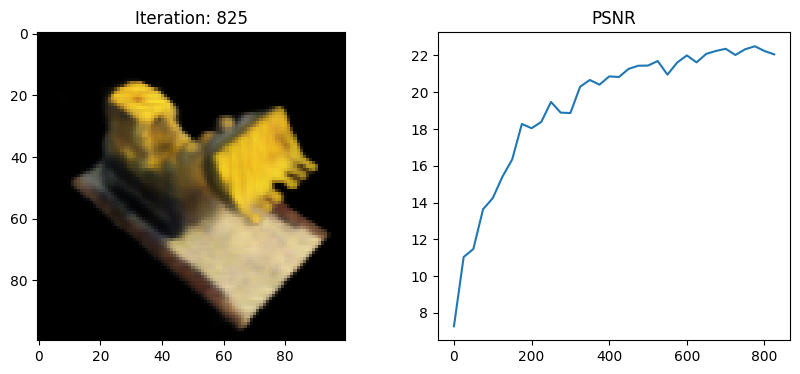

850 0.791203670501709 secs per iter


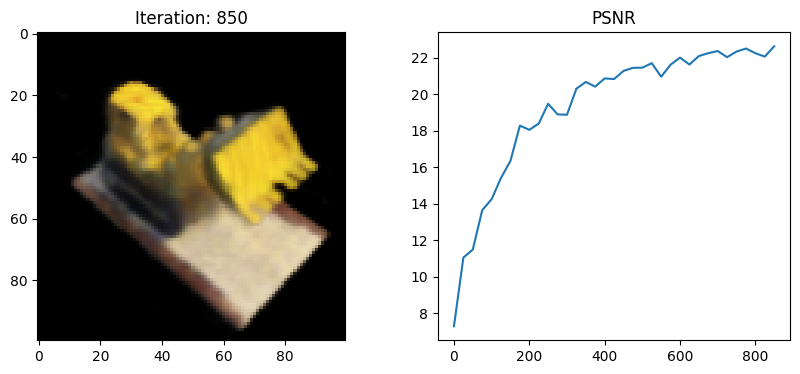

875 0.788374547958374 secs per iter


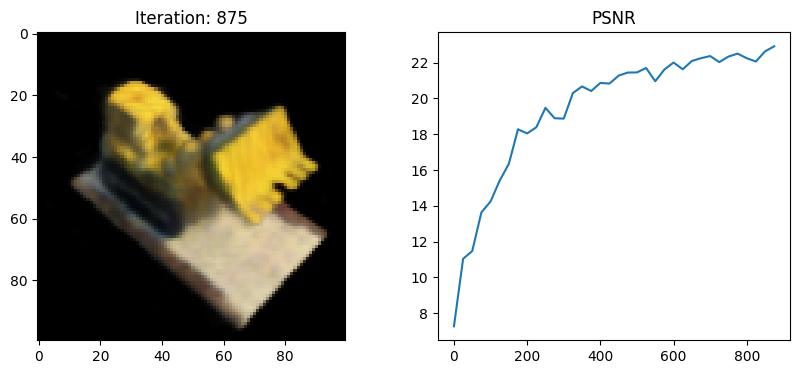

900 0.7858213710784913 secs per iter


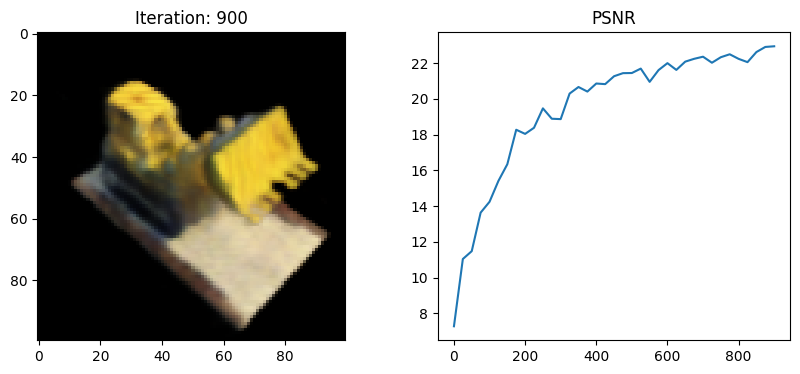

925 0.7896260738372802 secs per iter


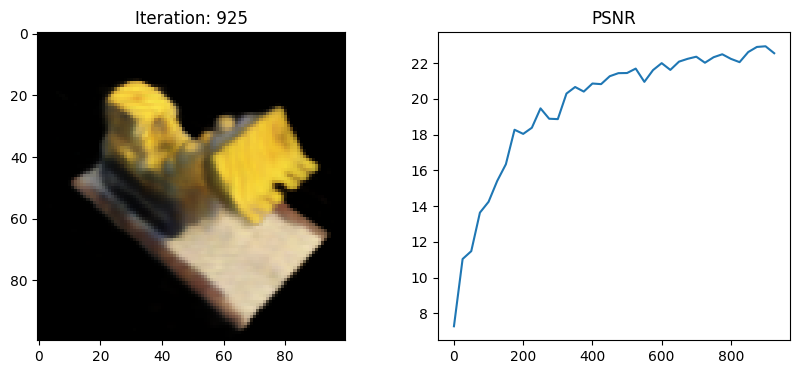

950 0.7905163669586182 secs per iter


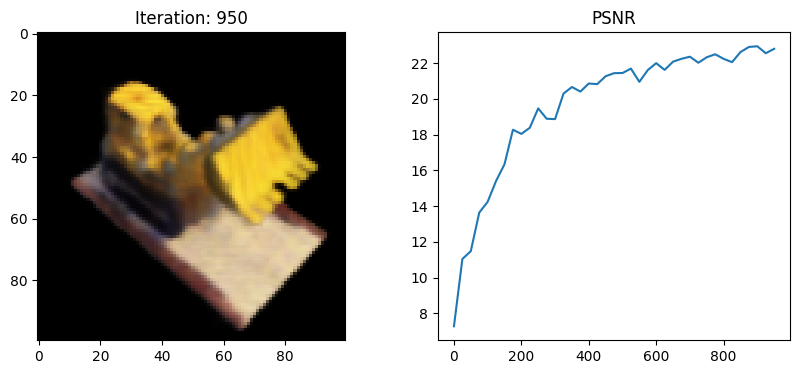

975 0.7798636150360108 secs per iter


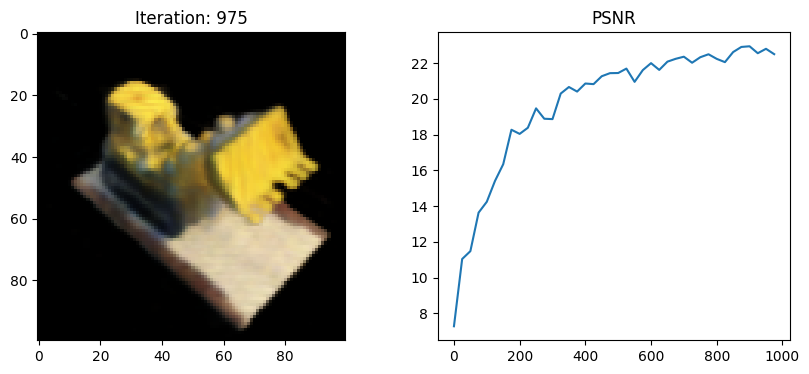

1000 0.7802720928192138 secs per iter


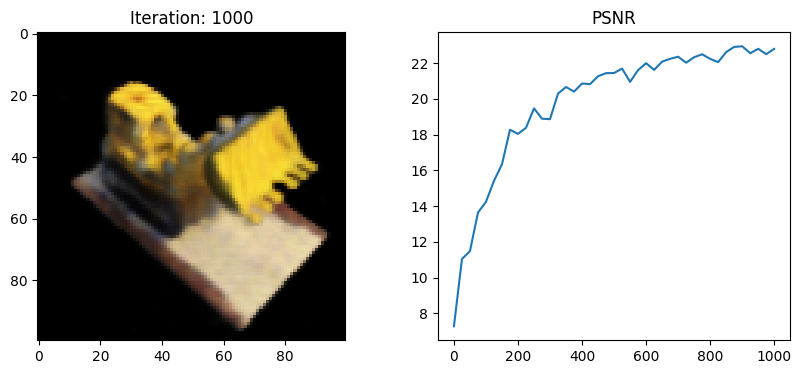

1025 0.785888032913208 secs per iter


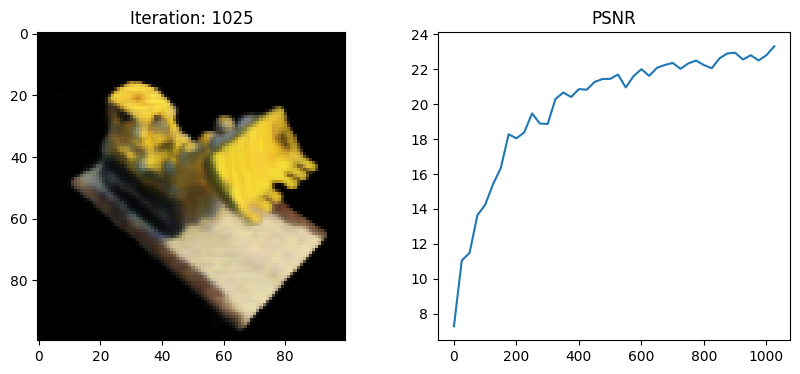

1050 0.7896644687652588 secs per iter


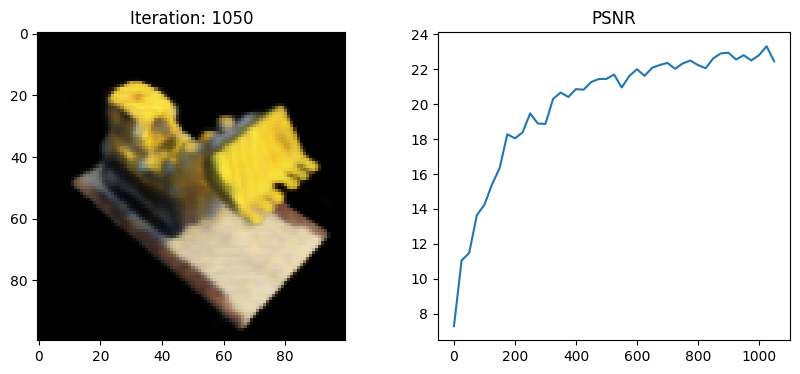

1075 0.7855054378509522 secs per iter


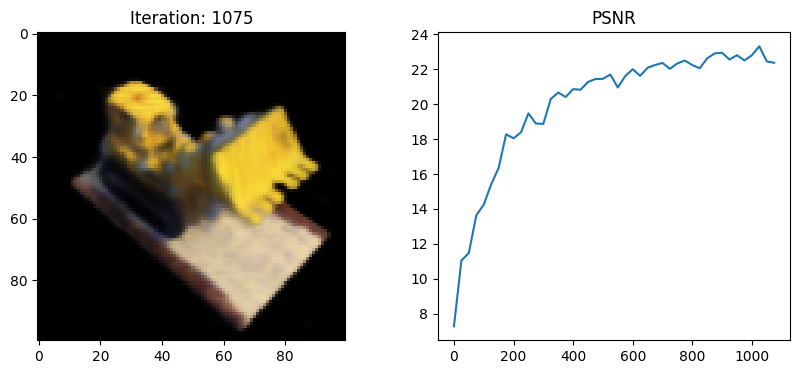

1100 0.7858770942687988 secs per iter


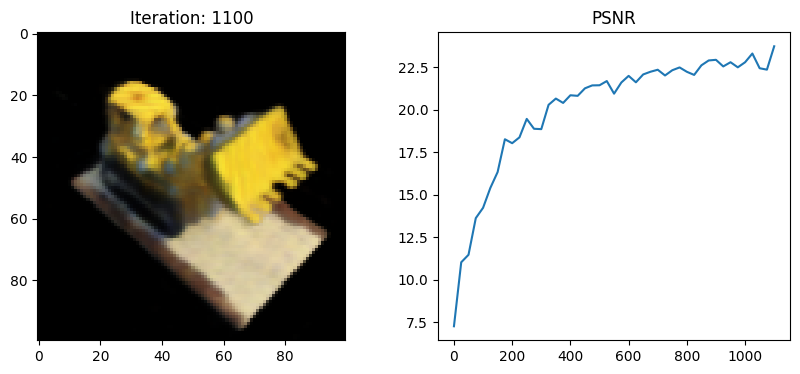

1125 0.7834185695648194 secs per iter


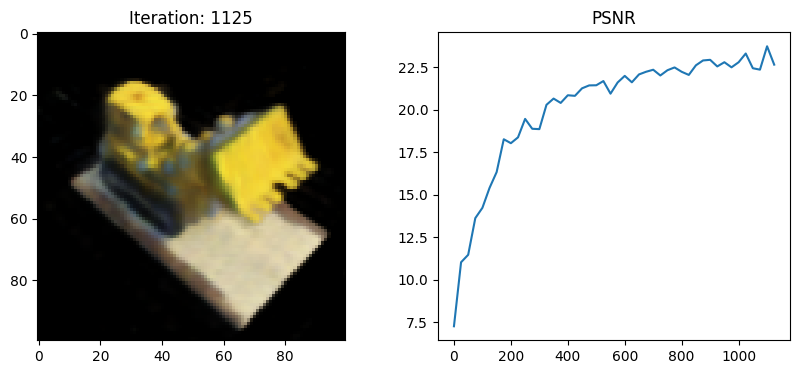

1150 0.7822659015655518 secs per iter


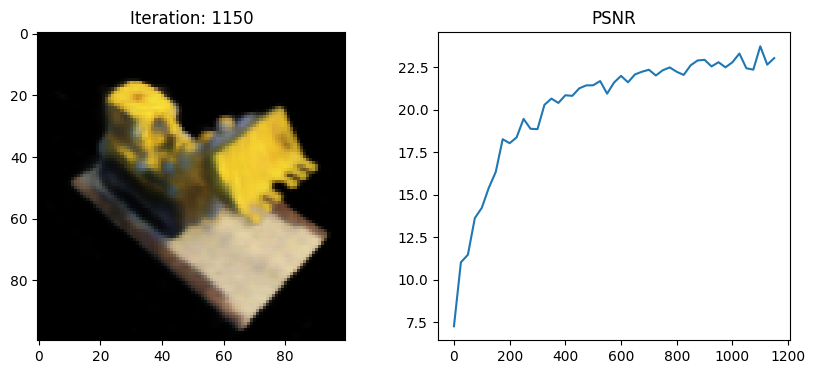

1175 0.7869495868682861 secs per iter


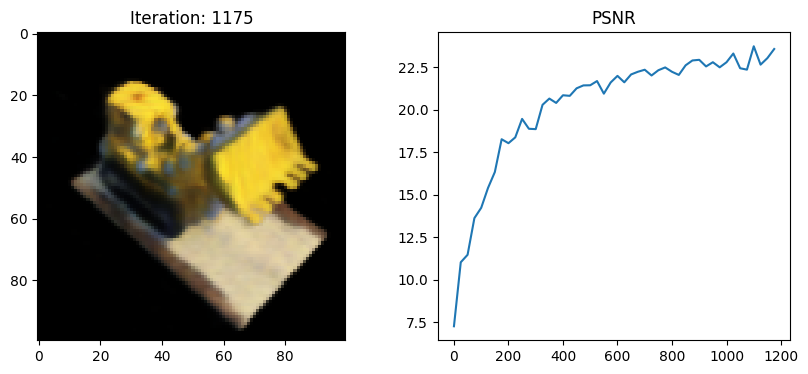

1200 0.7928072357177735 secs per iter


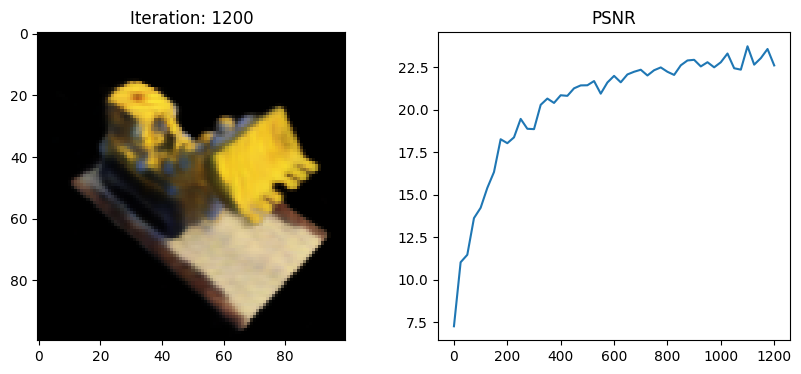

1225 0.7912353229522705 secs per iter


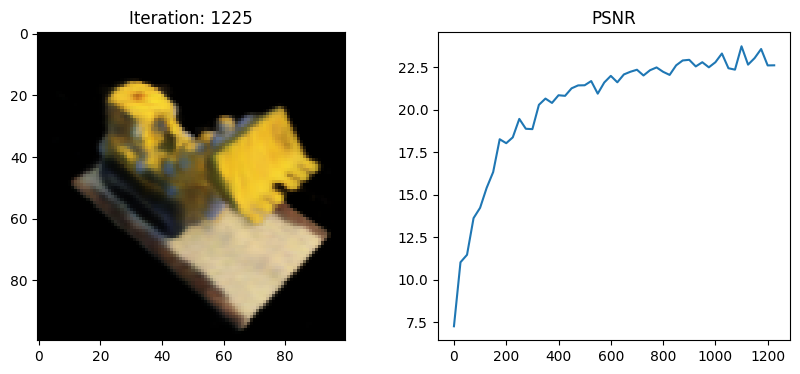

1250 0.7846767139434815 secs per iter


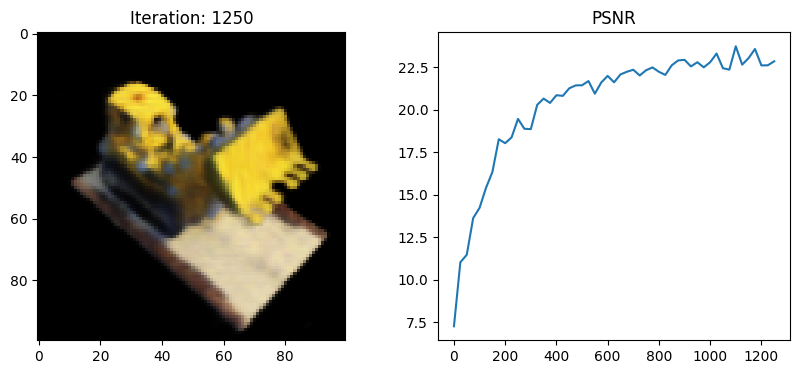

1275 0.7869035053253174 secs per iter


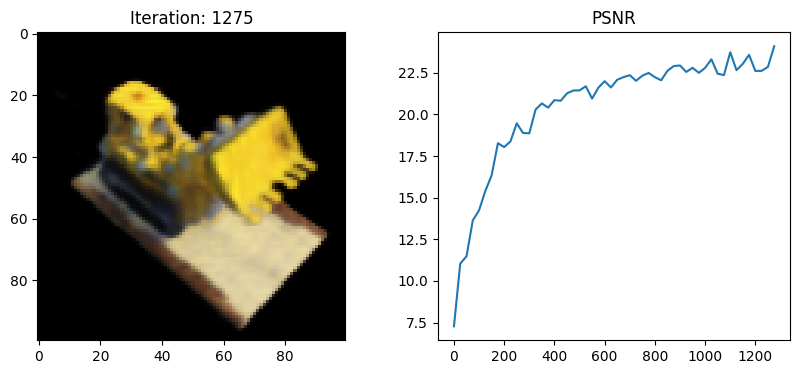

1300 0.7860657119750977 secs per iter


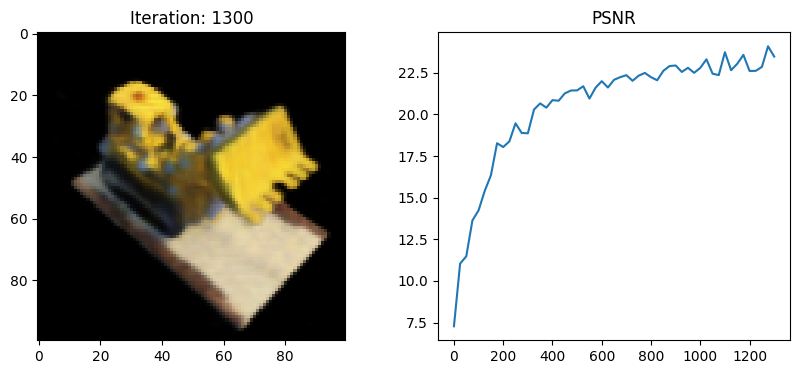

1325 0.7837354755401611 secs per iter


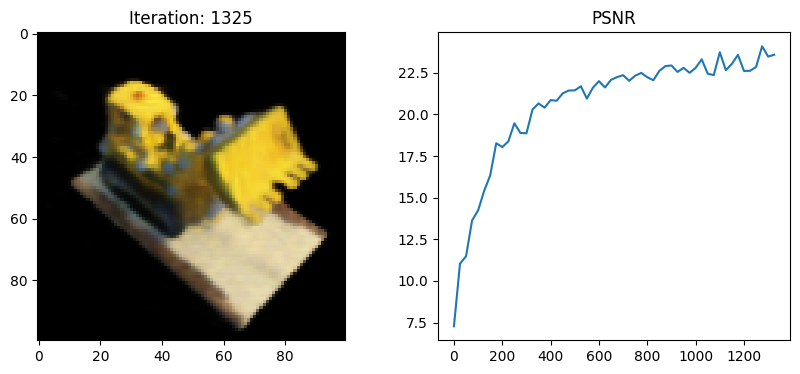

1350 0.7841204357147217 secs per iter


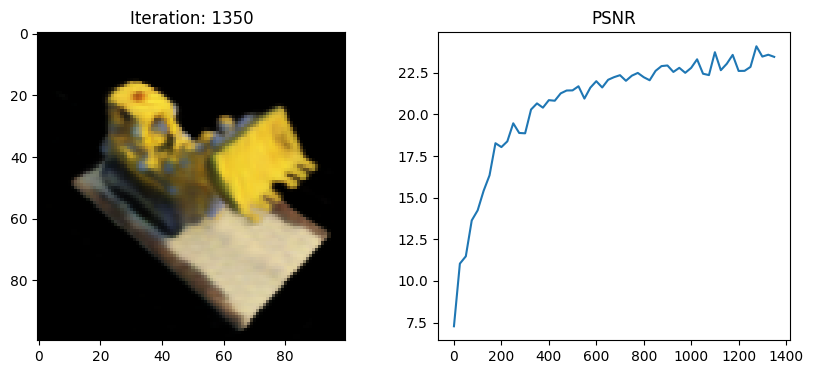

1375 0.7899795341491699 secs per iter


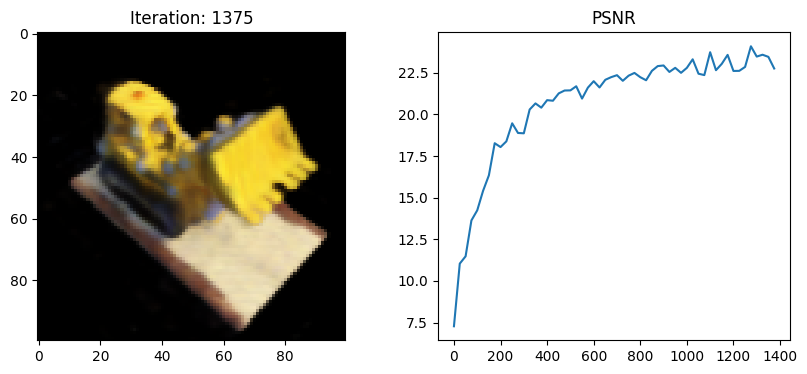

1400 0.7859013175964356 secs per iter


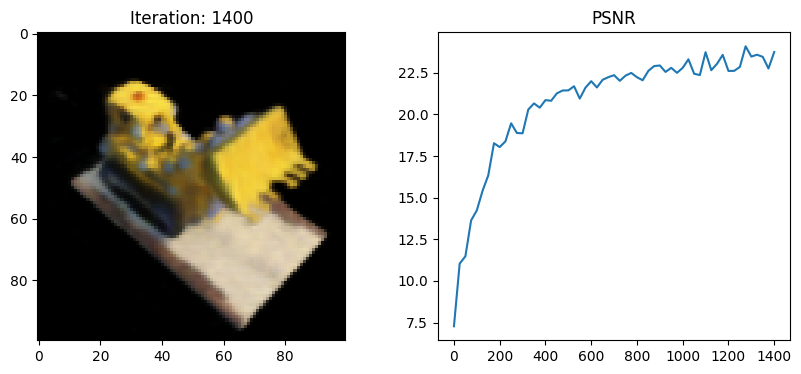

1425 0.7859549617767334 secs per iter


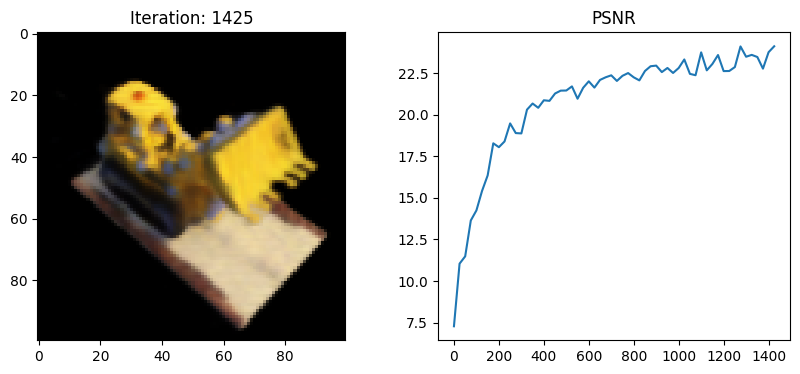

1450 0.786268367767334 secs per iter


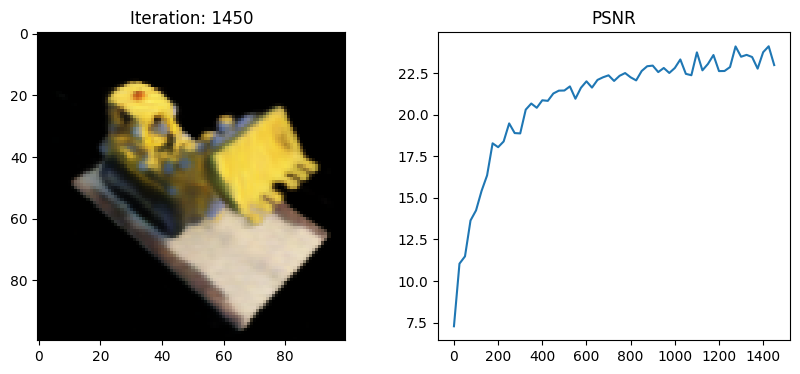

1475 0.7876387977600098 secs per iter


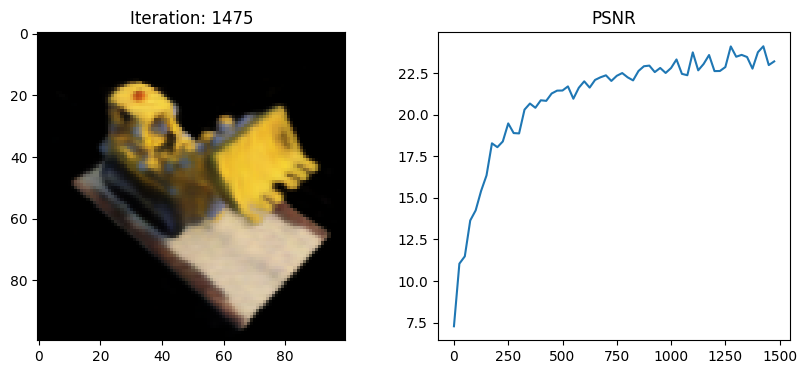

1500 0.7868333339691163 secs per iter


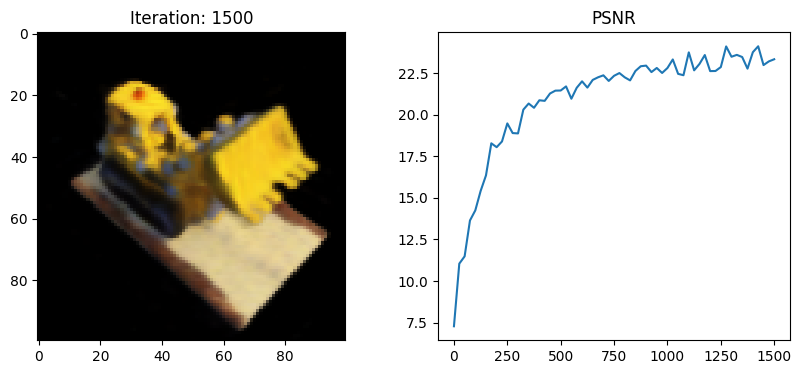

1525 0.7861614608764649 secs per iter


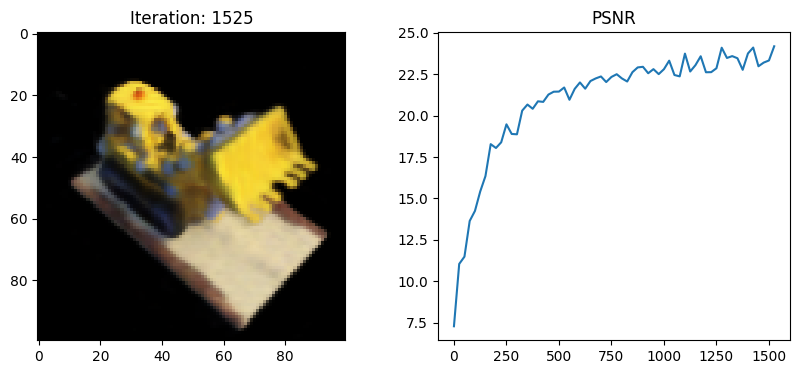

1550 0.7977690982818604 secs per iter


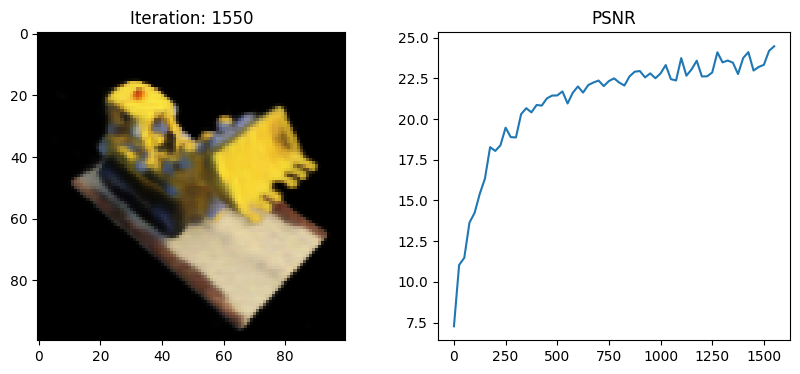

1575 0.7851361751556396 secs per iter


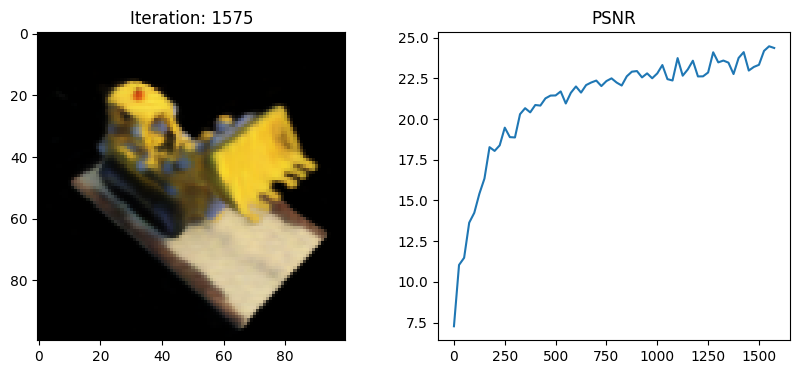

1600 0.7867536926269532 secs per iter


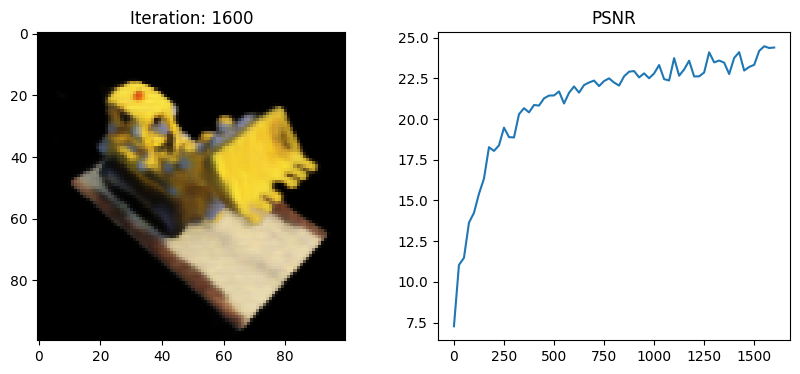

1625 0.7898101711273193 secs per iter


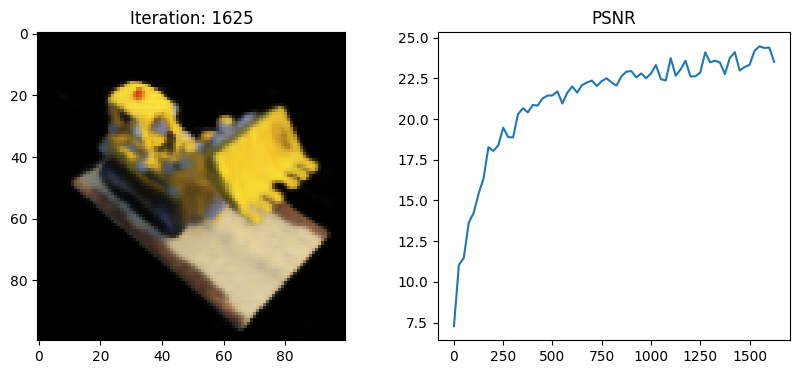

1650 0.7861850547790528 secs per iter


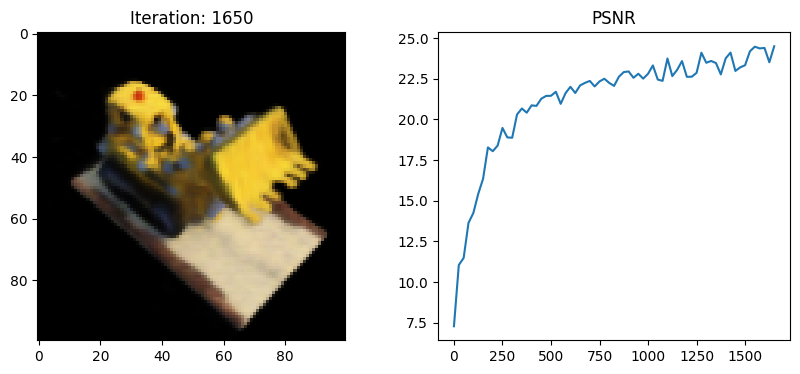

1675 0.7903907012939453 secs per iter


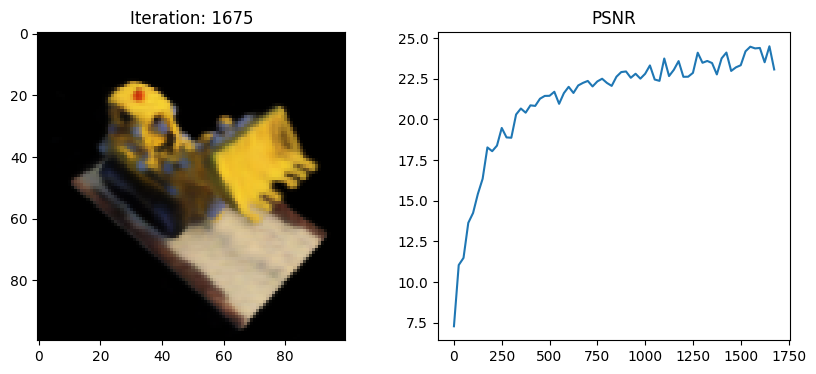

1700 0.7847143936157227 secs per iter


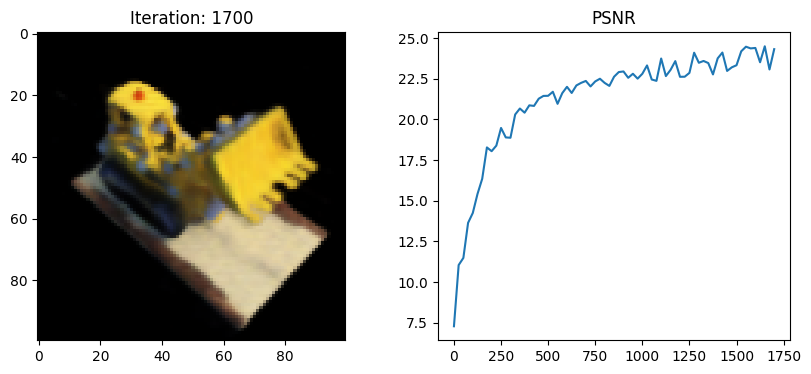

1725 0.7779054546356201 secs per iter


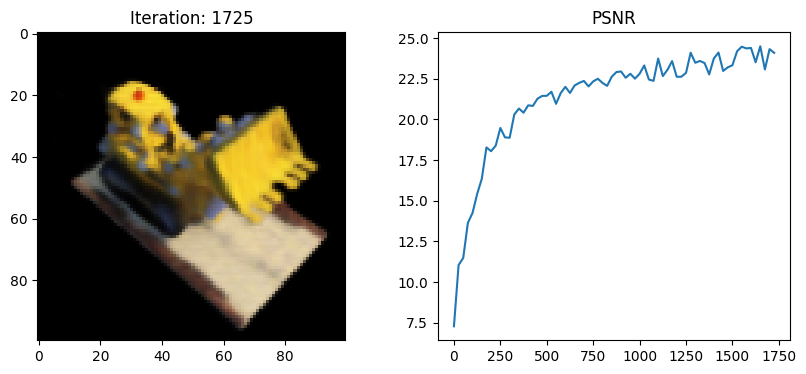

1750 0.7874325466156006 secs per iter


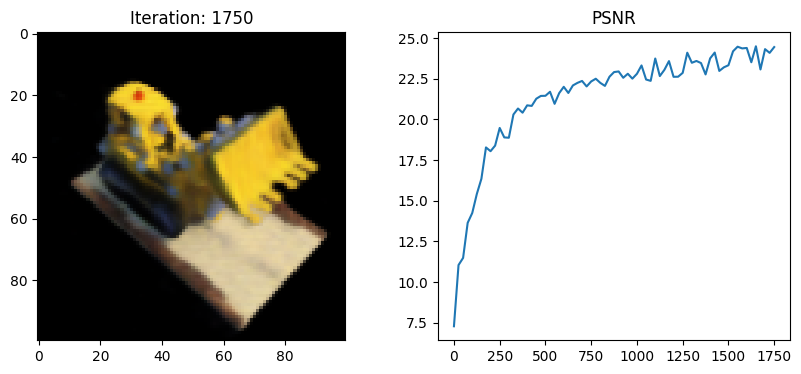

1775 0.7904900550842285 secs per iter


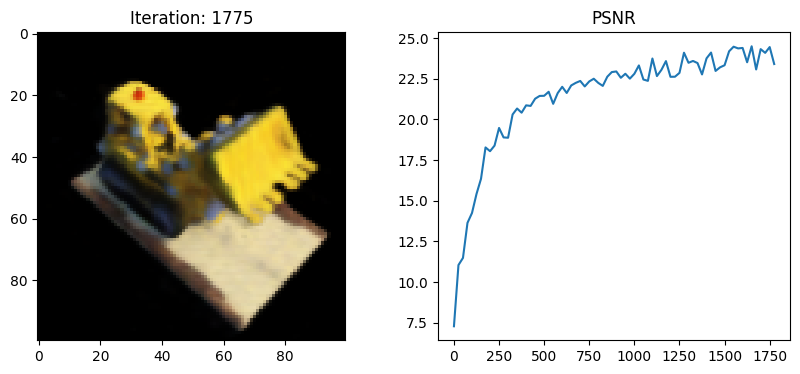

1800 0.7908582878112793 secs per iter


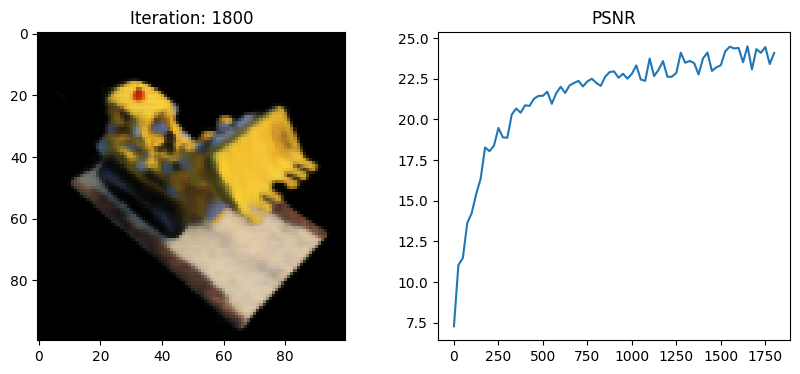

1825 0.7840158557891845 secs per iter


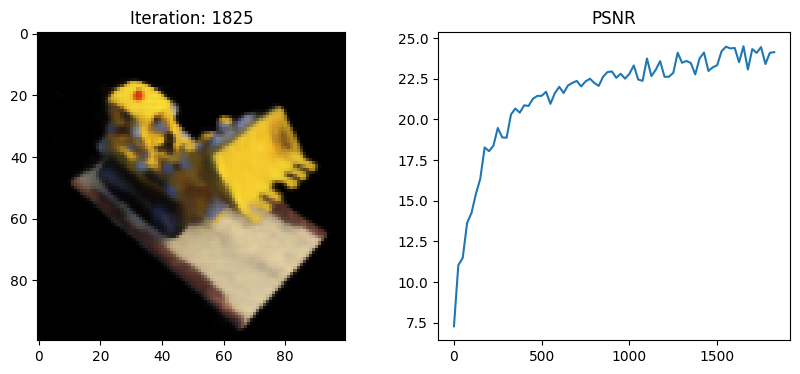

1850 0.7848050689697266 secs per iter


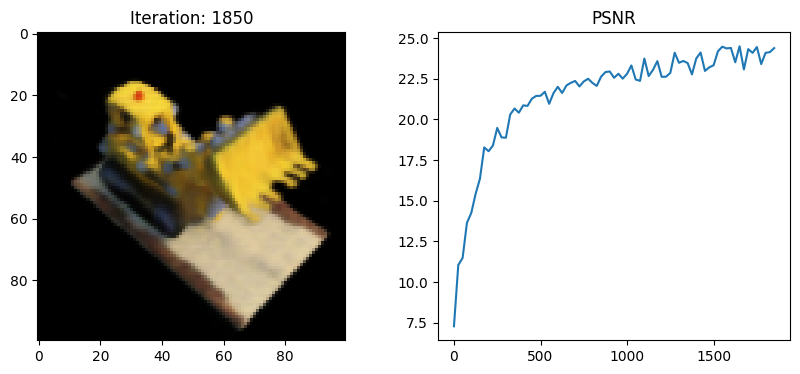

1875 0.7875767421722412 secs per iter


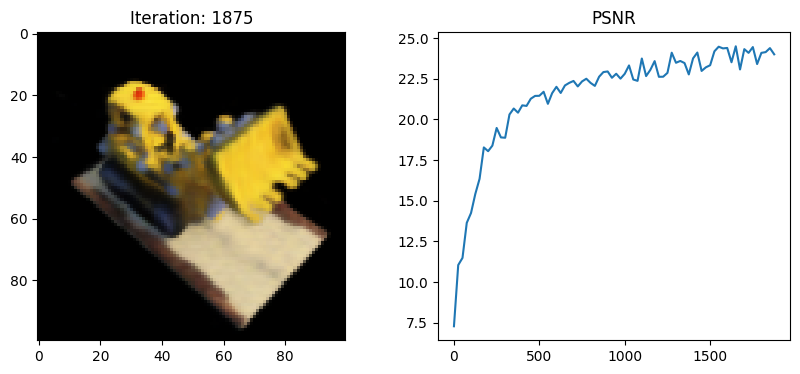

1900 0.7976345634460449 secs per iter


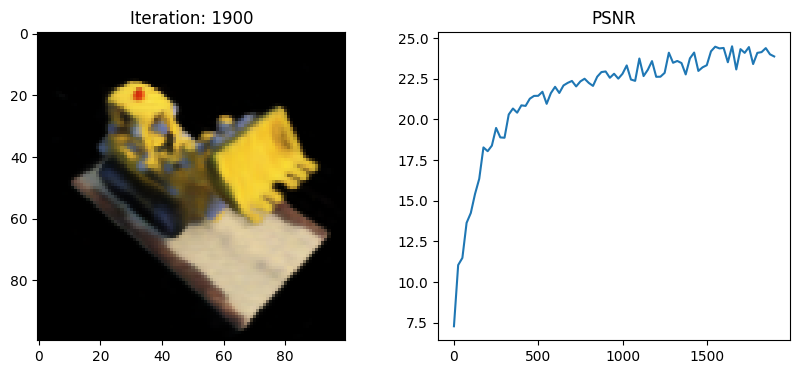

1925 0.7873512554168701 secs per iter


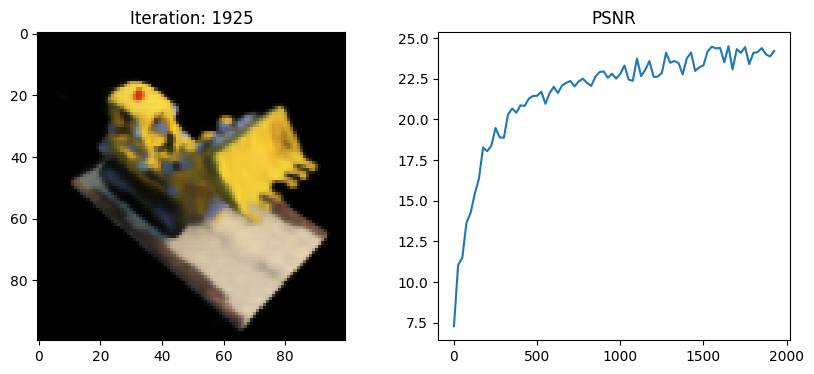

1950 0.7923006916046142 secs per iter


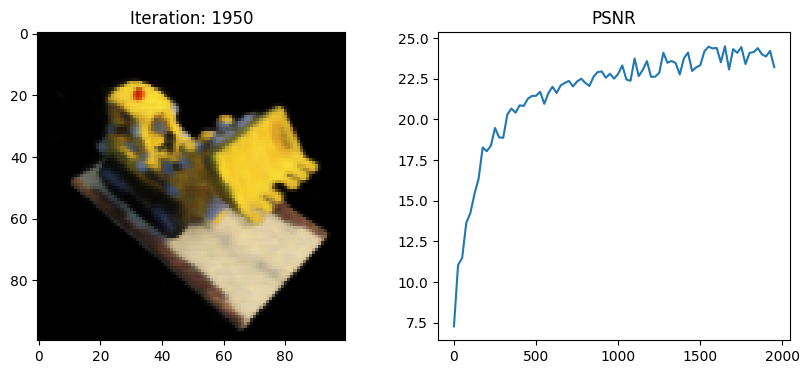

1975 0.7854510307312011 secs per iter


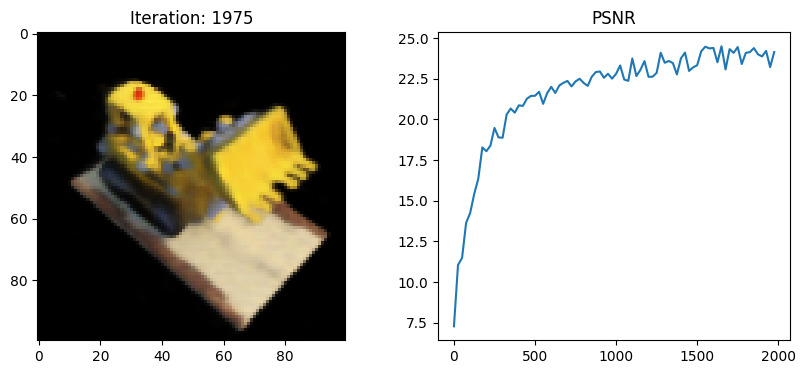

2000 0.7860947895050049 secs per iter


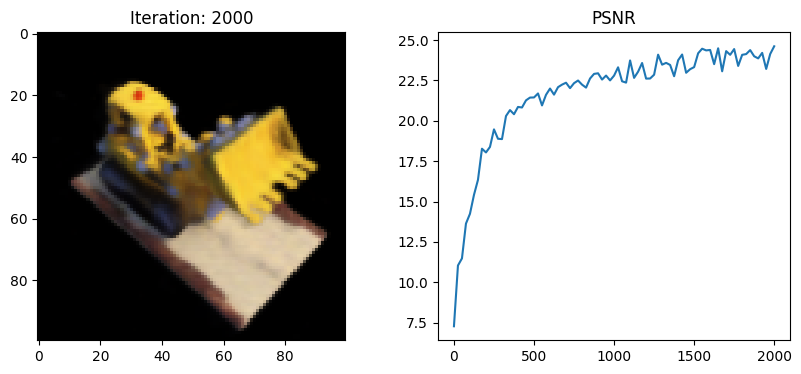

Done


In [ ]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 70
N_iters = 2000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

<ipython-input-7-bc28ed268829>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)